<a href="https://colab.research.google.com/github/lejrn/Reconstructing-Dark-Images/blob/main/TensorRawImage_v31.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing and Importing

In [ ]:
!pip install --upgrade fastai
!pip install --upgrade fastai-rawpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 11.6 MB/s 


In [ ]:
import fastai
from fastai.vision.all import *
from fastai.vision.data import *
#from fastai.callback import *
from fastairawpy import *
#import rawpy

from google.colab import drive
drive.mount('/content/drive')
fastai.__version__

Mounted at /content/drive


'2.7.9'

# Setting folders paths

Setting folders paths of labeled dataset

In [ ]:
path='/content/drive/MyDrive/Dataset'

modulus=5 # The camera shot 4 different EV exposure rates
input_symbol=x_mdls=3 # One of the darker EV exposure
target_symbol=y_mdls=4 # One of the lighter EV exposure
offset=y_mdls-x_mdls # Offset for the "get_target()" function
imageformat=".ORF"
imagetype="RAW" # Not JPG, Eww
dst_path_Short="RAW/Short"+str(input_symbol) # filename Short
dst_path_Long="RAW/Long"+str(target_symbol) # filename Long

path_long=path/Path(dst_path_Long) # For later use - path of the folder where the long exposure (light) images are in
path_short=path/Path(dst_path_Short) # For later use - path of the folder where the short exposure (dark) images are in

path_long,path_short

(Path('/content/drive/MyDrive/Dataset15/RAW/Long4'),
 Path('/content/drive/MyDrive/Dataset15/RAW/Short3'))

# Testing

Testing

(RAWImage mode=RGB size=1956x2620,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb1165f1890>)

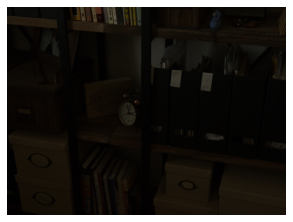

In [ ]:
imgs=get_image_files(path_short)
rwimg=RAWImage.create(fn=imgs[0], pr=rawpy.Params(output_color=rawpy.ColorSpace(2),demosaic_algorithm=rawpy.DemosaicAlgorithm(3),gamma=(1.3,3.3), bright=3, no_auto_bright=True, half_size=True, output_bps=16))
rwimg,rwimg.show()

# Dataset loading into DataBlock holder

Calculate the available batch sizes according to the GPU memory size and the model's size

In [ ]:
from math import sqrt
btchSize=2
imageSize=int(sqrt(2764800//btchSize)) # Resnet34
#imageSize=int(sqrt(524288//btchSize)) # Resnet50
imageSize

1175

Loading the files' paths into a datablock holder, so later on the GPU will access the files in every epoch and batch them up.

Also, setting transforms, splitters and other instructions of as how to read and prepare the images for the training

In [ ]:
from re import findall

def get_target(filename,postfix=".ORF"):
    return path_long/Path("P" + str(int(findall('\d+',filename.name)[0])+offset) + postfix)

dblock = DataBlock(blocks=(RawImageBlock(gamma=(1.3,3.3), # Input  
                                         output_color=rawpy.ColorSpace.ProPhoto, 
                                         bright=0.50, 
                                         no_auto_bright=True,
                                         four_color_rgb=True,
                                         highlight_mode=rawpy.HighlightMode.Reconstruct(3),
                                         #user_black=0,
                                         half_size=True, 
                                         output_bps=16),
                           RawImageBlock(use_camera_wb=True, # Target
                                         output_color=rawpy.ColorSpace.ProPhoto,
                                         four_color_rgb=True,
                                         highlight_mode=rawpy.HighlightMode.Reconstruct(3),
                                         half_size=True, 
                                         output_bps=16)
                           ),
                   splitter=RandomSplitter(seed=2023),
                   get_items = get_image_files,
                   get_y= get_target,
                   item_tfms=[RandomResizedCrop(size=512,min_scale=0.5)]
                   ,batch_tfms=[*aug_transforms(flip_vert=True,
                                                min_zoom=0.65, max_zoom=1.35, 
                                                max_rotate=5.0, # 50.0
                                                max_warp=0.25, 
                                                max_lighting=0,p_lighting=0
                                                ) #, IntToFloatTensor(div=65355.)]
                                ] 
                   )
dls = dblock.dataloaders(source=path_short,bs=btchSize,path=path,verbose=True)
dls.c=3 # Setting n_out // c=Channels

Found 107 items
2 datasets of sizes 86,21
Setting up Pipeline: partial
Setting up Pipeline: get_target -> partial
Setting up after_item: Pipeline: RandomResizedCrop -- {'size': (512, 512), 'min_scale': 0.5, 'ratio': (0.75, 1.3333333333333333), 'val_xtra': 0.14, 'max_scale': 1.0, 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 65535.0, 'div_mask': 1} -> Dihedral -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}


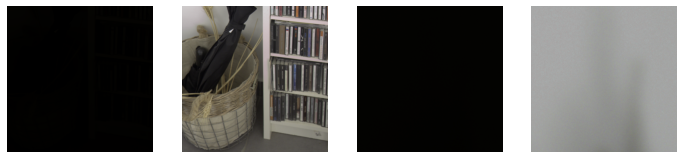

In [ ]:
dls.show_batch(max_n=btchSize)

In [ ]:
x,y = dls.one_batch()
x.shape,y.shape

(torch.Size([2, 3, 512, 512]), torch.Size([2, 3, 512, 512]))

Setting-up type transforms pipelines
Found 107 items
2 datasets of sizes 86,21
Setting up Pipeline: partial
Setting up Pipeline: get_target -> partial

Building one sample
  Pipeline: partial
    starting from
      /content/drive/MyDrive/Dataset15/RAW/Short3/P4280343.ORF
    applying partial gives
      RAWImage mode=RGB size=1956x2620
  Pipeline: get_target -> partial
    starting from
      /content/drive/MyDrive/Dataset15/RAW/Short3/P4280343.ORF
    applying get_target gives
      /content/drive/MyDrive/Dataset15/RAW/Long4/P4280344.ORF
    applying partial gives
      RAWImage mode=RGB size=1956x2620

Final sample: (RAWImage mode=RGB size=1956x2620, RAWImage mode=RGB size=1956x2620)


Found 107 items
2 datasets of sizes 86,21
Setting up Pipeline: partial
Setting up Pipeline: get_target -> partial
Setting up after_item: Pipeline: RandomResizedCrop -- {'size': (512, 512), 'min_scale': 0.5, 'ratio': (0.75, 1.3333333333333333), 'val_xtra': 0.14, 'max_scale': 1.0, 'p': 1.0} -> ToTensor


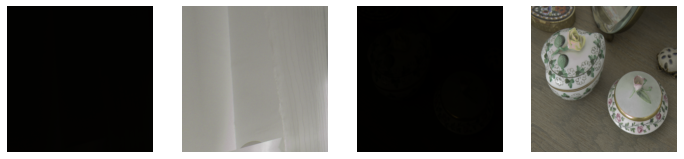

In [ ]:
dblock.summary(path_short,bs=btchSize,show_batch=True,max_n=btchSize)

# Configuring the metrics + architecture

In [ ]:
def psnr(pred, targs, data_range=1):
    mse = F.mse_loss(pred, targs)
    return 20 * torch.log10(data_range / torch.sqrt(mse))

import torch
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from math import exp

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

def ssim(img1, img2, window_size = 11, size_average = True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    
    return _ssim(img1, img2, window, window_size, channel, size_average)

In [ ]:
wd=1e-3
L1=F.l1_loss
L2=F.mse_loss
learnGEN=unet_learner(dls, resnet50, pretrained=True,loss_func=L1,metrics=[ssim,psnr])

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Optimizing the learning rate

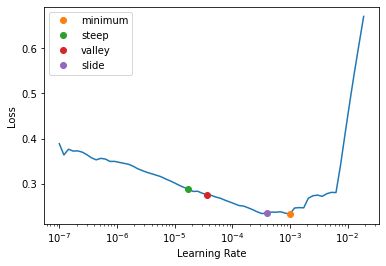

In [ ]:
lr_min,lr_steep,lr_valley,lr_slide = learnGEN.lr_find(suggest_funcs=(minimum, steep,valley,slide))

In [ ]:
@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs): # Special thanks to Ignacio Oguiza
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

# Training + Performance

In [ ]:
learnGEN.freeze()
learnGEN.fit_one_cycle(n_epoch=100,lr_max=1e-3,wd=wd)

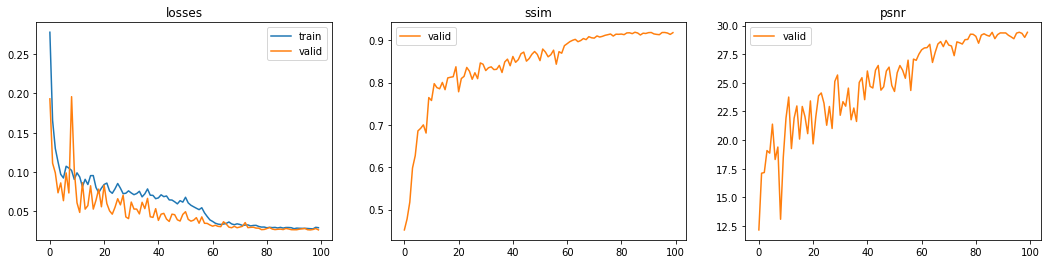

In [ ]:
learnGEN.recorder.plot_metrics()

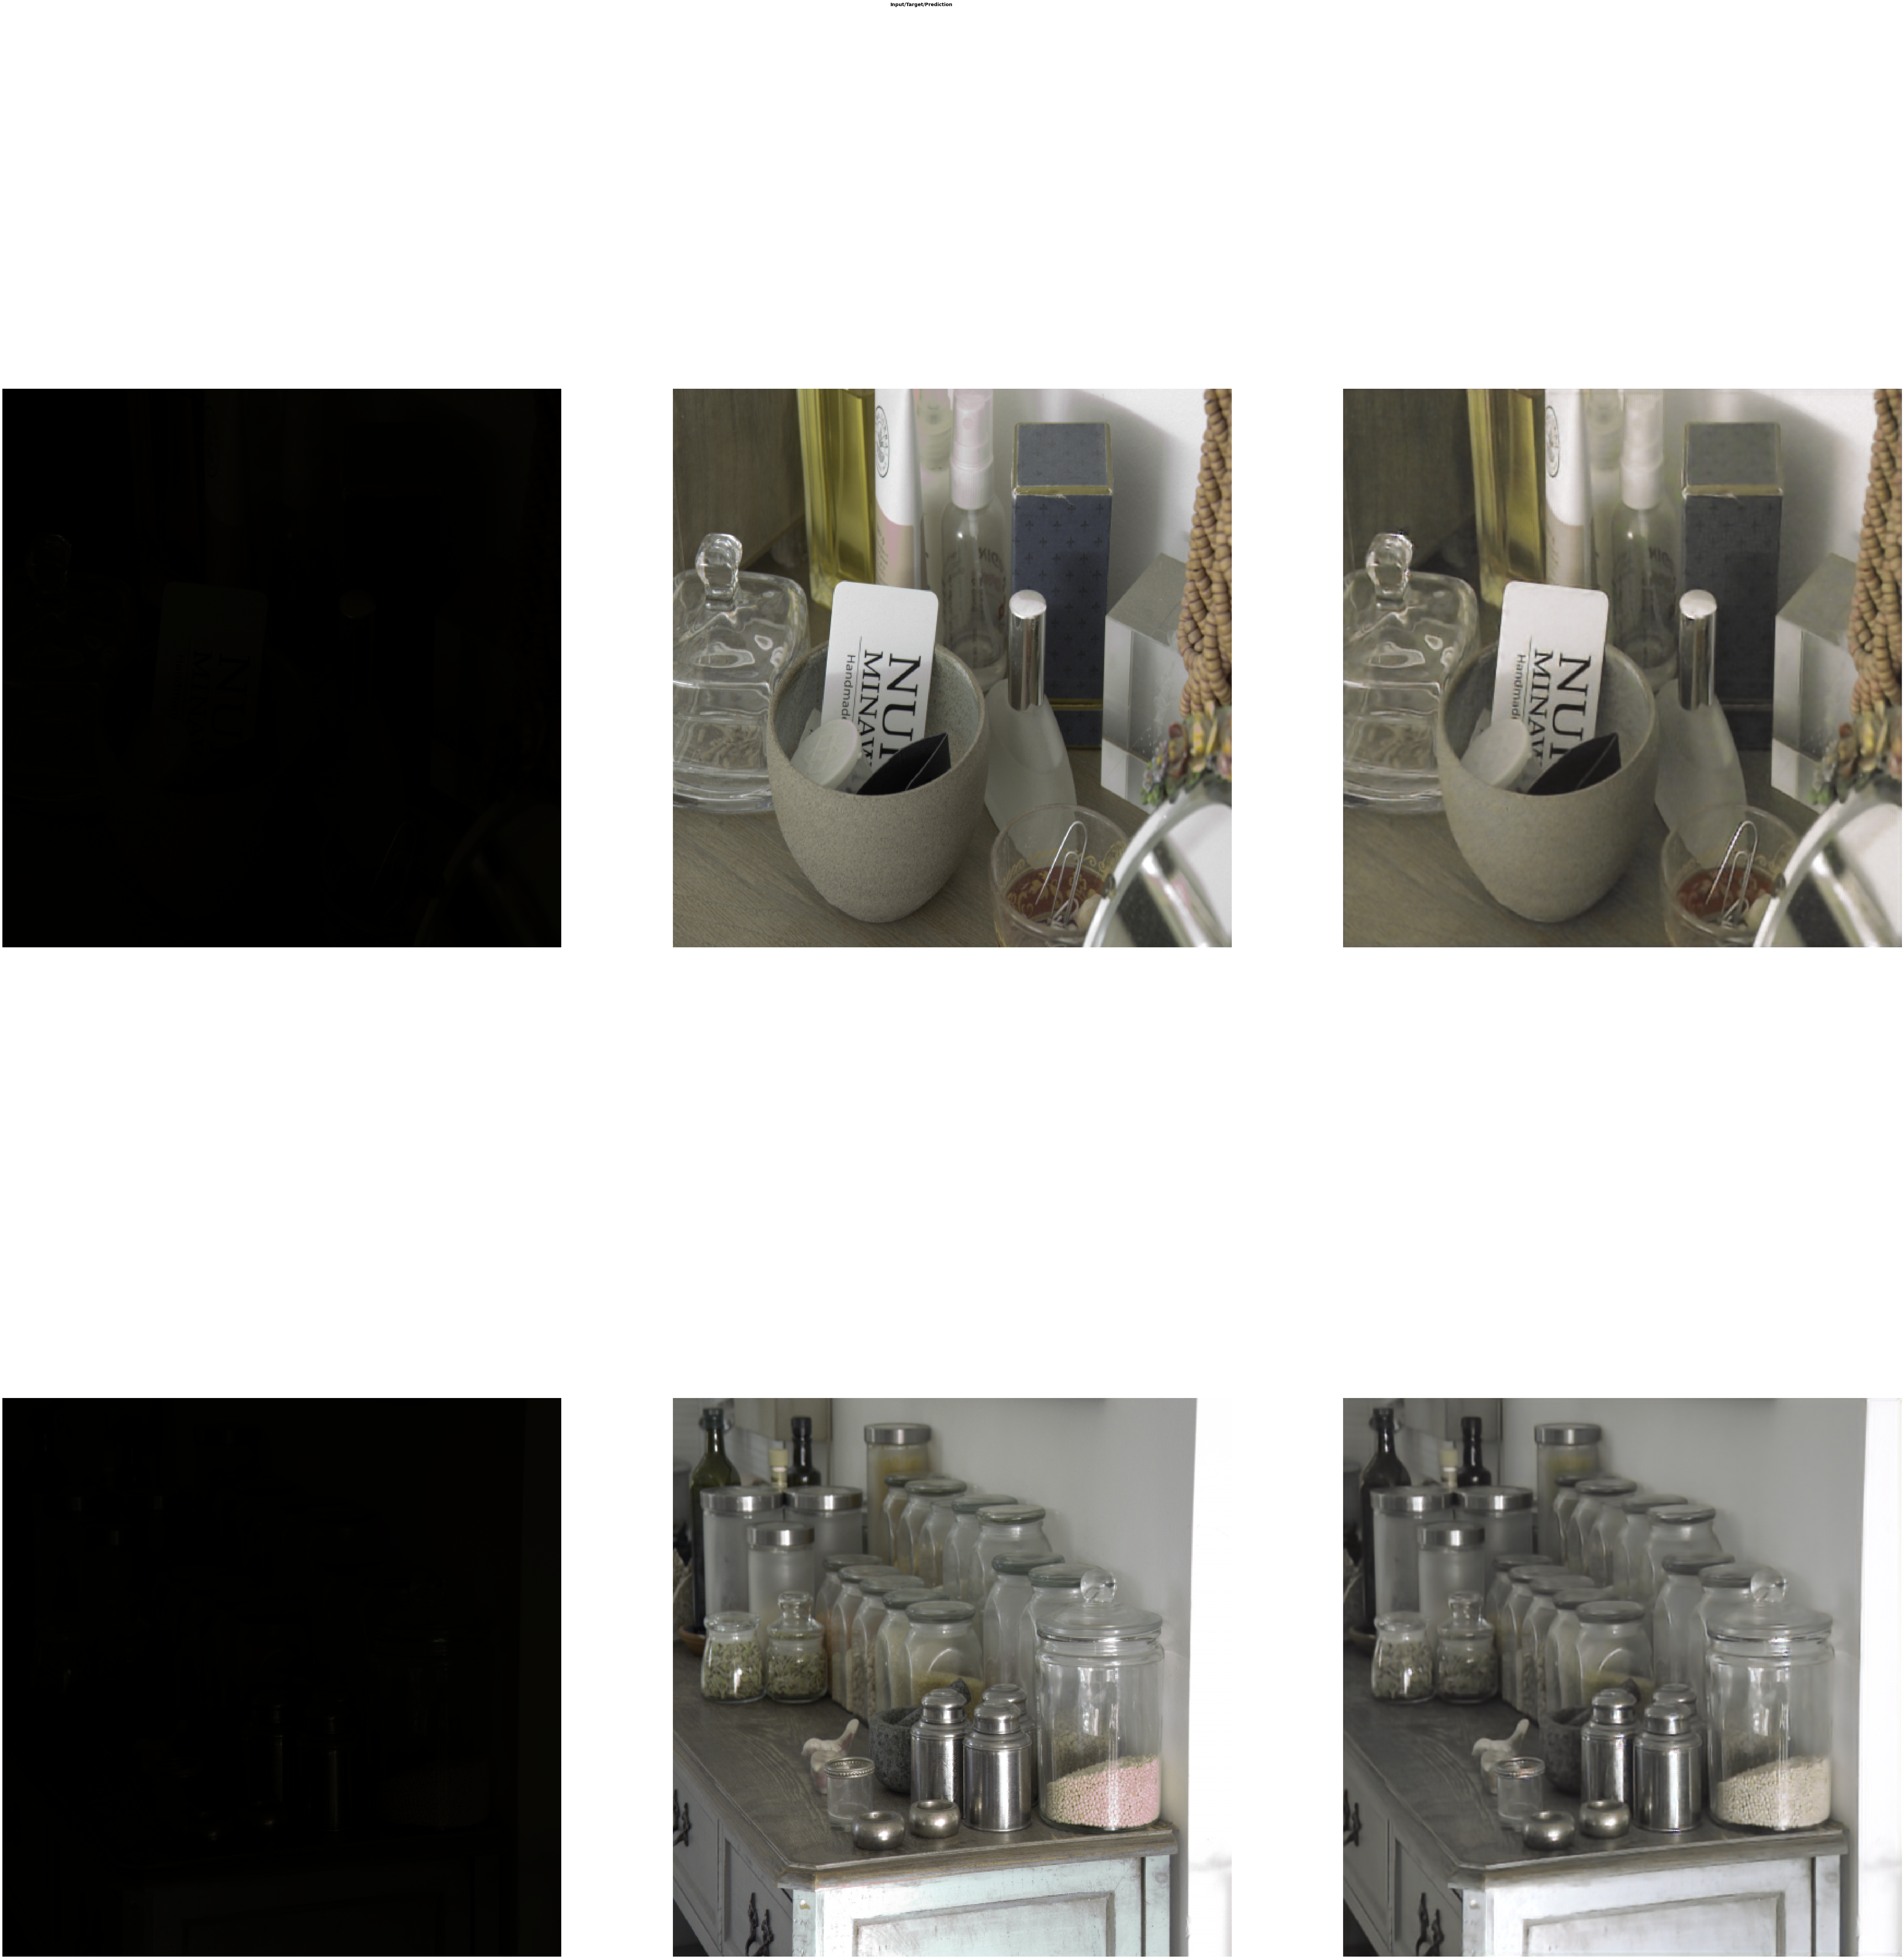

In [ ]:
learnGEN.show_results(figsize=(100,100))